In [12]:
import pandas as pd
from darts import TimeSeries
from darts.models import XGBModel
from darts.metrics import mse, rmse, r2_score, mae, smape, wmape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, facet_grid
)
import json


torch.set_float32_matmul_precision('medium')


In [13]:
target_columns = [
    'Temperature', 'Humidity', 'Soil_Moisture', 
    'Soil_Temperature', 
    'Precipitation_accumulated'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [14]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [15]:
best_mse = float('inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

# Listas para armazenar dados de todos os folds
all_forecasts = []
all_val_scaled = []
all_scalers = []
all_metrics_dfs = []
all_mse_scores = []
all_train_scaled = []
all_metrics_horizon = []

tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    target_lags_list = [-i for i in range(1, 29)]
    xgb_params = {
        'n_estimators': 300,
        'max_depth': 3,
        'learning_rate': 0.030261200230593657,
        'min_child_weight': 3,
        'subsample': 0.8,
        'colsample_bytree': 0.9,
        'gamma': 0.05,
        'reg_alpha': 0.0004599618568464162,
        'reg_lambda': 1.8500014715240622e-05,
        'n_jobs': -1
    }

    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    scaler = scaler.fit(train_fold)
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)

    model = XGBModel(
        lags=target_lags_list,
        output_chunk_length=1,
        add_encoders=encoders,
        **xgb_params
    )

    model.fit(
        series=train_scaled,
        val_series=val_scaled,
    )

    metrics_per_horizon = []
    for i in [1,4,8,12,16,20,24]:
        forecasts = model.historical_forecasts(
            val_scaled,
            forecast_horizon=i,
            stride=1,
            retrain=False,
            verbose=False,
            last_points_only=True,
        )

        forecasts_t = scaler.inverse_transform(forecasts)
        s = scaler.inverse_transform(val_scaled)
        metrics = {}
        print("Iniciando a verificação das séries temporais para constância...")
        try:
            for target in target_columns:
                metrics[target] = {
                    'MSE': mse(s[target], forecasts_t[target]),
                    'RMSE': rmse(s[target], forecasts_t[target]),
                    'MAE': mae(s[target], forecasts_t[target]),
                    'R2': r2_score(s[target], forecasts_t[target]),
                    'SMAPE': smape(s[target], forecasts_t[target]),
                    'WMAPE': wmape(s[target], forecasts_t[target]),
                }
            metrics_df = pd.DataFrame(metrics).T
            print("\nMétricas de performance:")
            print(metrics_df)
            metrics_per_horizon.append(metrics_df)
        except Exception as e:
            print(e)

    mse_geral = mse(s, forecasts_t)
    print(f"O MSE desse fold foi {mse_geral}")

    # Armazenar dados deste fold
    all_forecasts.append(forecasts)
    all_val_scaled.append(val_scaled)
    all_scalers.append(scaler)
    all_metrics_dfs.append(metrics_df)
    all_metrics_horizon.append(metrics_per_horizon)
    all_mse_scores.append(mse_geral)
    all_train_scaled.append(train_scaled)

    # Ainda mantemos o melhor fold para referência (agora baseado no MSE)
    if best_mse > mse_geral:
        best_mse = mse_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold (baseado no menor MSE) foi {best_fold}")

# Calcular a média dos R2 e MSE de todos os folds
avg_mse = sum(all_mse_scores) / len(all_mse_scores)
print(f"A média dos MSE de todos os folds foi {avg_mse:.4f}")

avg_metrics = {}
metric_names = ['MSE', 'RMSE', 'MAE', 'R2', 'SMAPE', 'WMAPE'] # Definir nomes das métricas

for target in target_columns:
    avg_metrics[target] = {} # Inicializar dicionário para o target atual
    for metric_name in metric_names:
        metric_values_for_fold = []
        # Coletar todos os valores válidos da métrica para o target atual em todos os folds
        for df_fold in all_metrics_dfs:
            # Verificar se o target existe como índice e a métrica como coluna no df_fold
            if target in df_fold.index and metric_name in df_fold.columns:
                value = df_fold.loc[target, metric_name]
                # Adicionar à lista apenas se não for NaN
                if pd.notna(value):
                    metric_values_for_fold.append(value)
        
        # Calcular a média apenas se houver valores válidos
        if metric_values_for_fold:
            avg_metrics[target][metric_name] = sum(metric_values_for_fold) / len(metric_values_for_fold)
        else:
            # Caso contrário, registrar NaN (ou outro valor padrão, se preferir)
            avg_metrics[target][metric_name] = float('nan')

avg_metrics_df = pd.DataFrame(avg_metrics).T
print("\nMétricas médias de performance de todos os folds:")
print(avg_metrics_df)


with open('all_metrics_horizon.json', 'w') as f:
    all_metrics_horizon_dict = [
        [df.to_dict() for df in fold_metrics] for fold_metrics in all_metrics_horizon
    ]
    json.dump(all_metrics_horizon_dict, f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

print("\nUsando a média dos folds para análise...")

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.



Fold 1

Treinando o modelo...
Train set: 1389 samples
Validation set: 1384 samples
[0]	validation_0-rmse:41.34107
[1]	validation_0-rmse:41.33783
[2]	validation_0-rmse:41.33469
[3]	validation_0-rmse:41.33165
[4]	validation_0-rmse:41.32870
[5]	validation_0-rmse:41.32584
[6]	validation_0-rmse:41.32307
[7]	validation_0-rmse:41.32040
[8]	validation_0-rmse:41.31780
[9]	validation_0-rmse:41.31529
[10]	validation_0-rmse:41.31286
[11]	validation_0-rmse:41.31050
[12]	validation_0-rmse:41.30820
[13]	validation_0-rmse:41.30599
[14]	validation_0-rmse:41.30384
[15]	validation_0-rmse:41.30176
[16]	validation_0-rmse:41.29975
[17]	validation_0-rmse:41.29779
[18]	validation_0-rmse:41.29588
[19]	validation_0-rmse:41.29404
[20]	validation_0-rmse:41.29225
[21]	validation_0-rmse:41.29053
[22]	validation_0-rmse:41.28886
[23]	validation_0-rmse:41.28723
[24]	validation_0-rmse:41.28567
[25]	validation_0-rmse:41.28413
[26]	validation_0-rmse:41.28265
[27]	validation_0-rmse:41.28121
[28]	validation_0-rmse:41.2798

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.



Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     3.265552    1.807084    1.212936  0.928656   
Humidity                       20.052964    4.478054    3.156121  0.933328   
Soil_Moisture              483140.938467  695.083404  450.769254  0.603223   
Soil_Temperature                4.960828    2.227292    1.433439  0.912373   
Precipitation_accumulated   58369.583752  241.597980  130.936754 -0.415869   

                               SMAPE      WMAPE  
Temperature                 8.525800   7.334698  
Humidity                    4.566825   4.137778  
Soil_Moisture               6.156886   5.620765  
Soil_Temperature            9.534172   8.723552  
Precipitation_accumulated  88.851779  98.078140  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     8.697786    2.949201    2.169884  0.810240   
Humidity                       56.763459    7.534153    5.827082  0.811421   
Soil_Moisture              855424.413024  924.891568  627.259537  0.298611   
Soil_Temperature                8.589927    2.930858    2.170180  0.848508   
Precipitation_accumulated   58499.395376  241.866483  131.228245 -0.417184   

                               SMAPE      WMAPE  
Temperature                14.842306  13.114152  
Humidity                    8.299522   7.642349  
Soil_Moisture               8.320384   7.822725  
Soil_Temperature           14.879561  13.199983  
Precipitation_accumulated  89.075422  98.083308  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    11.042108    3.322967    2.477532  0.759506   
Humidity                       77.374759    8.796292    7.042614  0.743615   
Soil_Moisture              892020.764869  944.468509  655.292926  0.269814   
Soil_Temperature               10.361282    3.218895    2.426880  0.817319   
Precipitation_accumulated   58672.855366  242.224803  131.617010 -0.418936   

                               SMAPE      WMAPE  
Temperature                17.158786  14.982744  
Humidity                    9.922559   9.235488  
Soil_Moisture               8.652352   8.174552  
Soil_Temperature           16.893595  14.775891  
Precipitation_accumulated  89.326282  98.088865  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    11.501679    3.391413    2.521749  0.749393   
Humidity                       84.762263    9.206642    7.401784  0.719601   
Soil_Moisture              916721.392096  957.455687  672.720021  0.250523   
Soil_Temperature               10.751177    3.278899    2.455648  0.810046   
Precipitation_accumulated   58847.320446  242.584667  132.007993 -0.420702   

                               SMAPE      WMAPE  
Temperature                17.538533  15.269763  
Humidity                   10.402625   9.702214  
Soil_Moisture               8.857404   8.394569  
Soil_Temperature           17.195396  14.977213  
Precipitation_accumulated  89.576377  98.094396  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    11.455013    3.384526    2.521723  0.750908   
Humidity                       87.485503    9.353369    7.554840  0.710909   
Soil_Moisture              936435.164540  967.695802  686.619718  0.235201   
Soil_Temperature               10.749318    3.278615    2.446418  0.810542   
Precipitation_accumulated   59022.805556  242.946096  132.401244 -0.422481   

                               SMAPE      WMAPE  
Temperature                17.536635  15.271208  
Humidity                   10.606679   9.905318  
Soil_Moisture               9.020432   8.570860  
Soil_Temperature           17.131742  14.921716  
Precipitation_accumulated  89.826469  98.099908  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    11.494589    3.390367    2.519957  0.750490   
Humidity                       86.599742    9.305898    7.514709  0.713646   
Soil_Moisture              951011.846208  975.198362  697.285280  0.224123   
Soil_Temperature               10.762001    3.280549    2.447847  0.810718   
Precipitation_accumulated   59199.276437  243.309014  132.796763 -0.424275   

                               SMAPE      WMAPE  
Temperature                17.521458  15.248613  
Humidity                   10.543685   9.860123  
Soil_Moisture               9.145325   8.706877  
Soil_Temperature           17.126429  14.919364  
Precipitation_accumulated  90.077878  98.105361  


Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    11.159299    3.340554    2.513291  0.758031   
Humidity                       86.119490    9.280059    7.427847  0.714933   
Soil_Moisture              945573.112855  972.405838  701.048479  0.229456   
Soil_Temperature               10.515429    3.242750    2.442206  0.815348   
Precipitation_accumulated   59376.912466  243.673783  133.194790 -0.426086   

                               SMAPE      WMAPE  
Temperature                17.521059  15.193338  
Humidity                   10.466220   9.753900  
Soil_Moisture               9.187085   8.756706  
Soil_Temperature           17.121647  14.870931  
Precipitation_accumulated  90.330928  98.110914  
O MSE desse fold foi 201011.56390764774

Fold 2

Treinando o modelo...
Train set: 2773 samples
Validation set: 1384 samples
[0]	validation_0-

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE           R2  \
Temperature                   1.583608   1.258415   0.999647     0.815492   
Humidity                      8.016498   2.831342   2.051468     0.612744   
Soil_Moisture              4556.835556  67.504337  58.487330     0.212012   
Soil_Temperature              2.469352   1.571417   1.264903     0.729547   
Precipitation_accumulated    32.889656   5.734950   5.734293 -4361.646434   

                              SMAPE     WMAPE  
Temperature                6.642766  6.378279  
Humidity                   2.421058  2.383968  
Soil_Moisture              0.912708  0.917120  
Soil_Temperature           8.378257  8.068021  
Precipitation_accumulated  1.259605  1.251724  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE           R2  \
Temperature                   2.189597   1.479729   1.226089     0.742737   
Humidity                     10.789321   3.284710   2.388338     0.479277   
Soil_Moisture              5113.072697  71.505753  61.654083     0.112615   
Soil_Temperature              3.017562   1.737113   1.425606     0.667474   
Precipitation_accumulated    32.901531   5.735986   5.735360 -4583.829727   

                              SMAPE     WMAPE  
Temperature                8.446230  7.831567  
Humidity                   2.823930  2.775797  
Soil_Moisture              0.962071  0.966726  
Soil_Temperature           9.669556  9.102132  
Precipitation_accumulated  1.259838  1.251954  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE           R2  \
Temperature                   2.361617   1.536755   1.275135     0.720419   
Humidity                     12.267018   3.502430   2.533614     0.408725   
Soil_Moisture              5490.889546  74.100537  63.586654     0.044297   
Soil_Temperature              3.128784   1.768837   1.454940     0.653204   
Precipitation_accumulated    32.913477   5.737027   5.736433 -4832.842338   

                              SMAPE     WMAPE  
Temperature                9.002175  8.153328  
Humidity                   3.000577  2.944989  
Soil_Moisture              0.992157  0.996979  
Soil_Temperature           9.965907  9.298549  
Precipitation_accumulated  1.260073  1.252185  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE           R2  \
Temperature                   2.428554   1.558382   1.285106     0.709884   
Humidity                     12.814596   3.579748   2.627441     0.383494   
Soil_Moisture              5649.871308  75.165626  64.692770     0.013224   
Soil_Temperature              3.172146   1.781052   1.464454     0.646195   
Precipitation_accumulated    32.925495   5.738074   5.737513 -5113.840715   

                               SMAPE     WMAPE  
Temperature                 9.177853  8.226203  
Humidity                    3.108772  3.054342  
Soil_Moisture               1.009335  1.014270  
Soil_Temperature           10.063776  9.368761  
Precipitation_accumulated   1.260308  1.252418  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE           R2  \
Temperature                   2.428575   1.558389   1.283952     0.706645   
Humidity                     13.041769   3.611339   2.693016     0.373377   
Soil_Moisture              5790.117325  76.092820  65.379304    -0.016191   
Soil_Temperature              3.167331   1.779700   1.461948     0.644201   
Precipitation_accumulated    32.937584   5.739127   5.738599 -5433.393146   

                               SMAPE     WMAPE  
Temperature                 9.176832  8.228669  
Humidity                    3.182040  3.130941  
Soil_Moisture               1.019986  1.024974  
Soil_Temperature           10.036740  9.362577  
Precipitation_accumulated   1.260546  1.252652  


Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE           R2  \
Temperature                   2.990693   1.729362   1.459776     0.635051   
Humidity                     12.534332   3.540386   2.681657     0.396754   
Soil_Moisture              6017.225074  77.570775  66.619422    -0.061295   
Soil_Temperature              3.670167   1.915768   1.605590     0.584756   
Precipitation_accumulated    32.949746   5.740187   5.739692 -5799.998466   

                               SMAPE      WMAPE  
Temperature                10.330969   9.366322  
Humidity                    3.156105   3.118349  
Soil_Moisture               1.039238   1.044356  
Soil_Temperature           11.030822  10.293308  
Precipitation_accumulated   1.260784   1.252887  
O MSE desse fold foi 1213.874002560429

Fold 3

Treinando o modelo...
Train set: 4157 samples
Validation set: 1384 samples
[0]	validation_0-rmse:0.

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.



Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     0.111610    0.334080    0.242746    0.817107   
Humidity                        0.400499    0.632850    0.423482    0.957235   
Soil_Moisture              172398.755980  415.209292  369.340810   -3.407829   
Soil_Temperature                0.158203    0.397748    0.375812    0.303392   
Precipitation_accumulated       5.451914    2.334933    2.326233 -133.428946   

                              SMAPE     WMAPE  
Temperature                2.654933  2.605086  
Humidity                   0.467592  0.464947  
Soil_Moisture              6.078318  6.212136  
Soil_Temperature           3.911778  3.829334  
Precipitation_accumulated  0.508726  0.507445  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     0.488518    0.698941    0.551907    0.193916   
Humidity                        1.417283    1.190497    0.879912    0.848987   
Soil_Moisture              212246.069242  460.701714  418.511767   -4.479431   
Soil_Temperature                1.293566    1.137351    1.110114   -4.764968   
Precipitation_accumulated       6.095612    2.468929    2.460707 -149.390395   

                               SMAPE      WMAPE  
Temperature                 6.060755   5.925140  
Humidity                    0.967381   0.966056  
Soil_Moisture               6.853869   7.040367  
Soil_Temperature           11.995012  11.314567  
Precipitation_accumulated   0.538213   0.536778  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     0.657300    0.810740    0.650129   -0.095794   
Humidity                        2.041257    1.428726    1.118092    0.783141   
Soil_Moisture              248184.897997  498.181591  458.689164   -5.493580   
Soil_Temperature                2.070557    1.438943    1.394350   -8.396408   
Precipitation_accumulated       6.098893    2.469594    2.461381 -149.594705   

                               SMAPE      WMAPE  
Temperature                 7.176966   6.983264  
Humidity                    1.227228   1.227544  
Soil_Moisture               7.483377   7.718019  
Soil_Temperature           15.247307  14.216978  
Precipitation_accumulated   0.538360   0.536925  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     0.648372    0.805216    0.643783   -0.091835   
Humidity                        2.640285    1.624895    1.284406    0.720323   
Soil_Moisture              255888.419878  505.854149  467.194596   -5.788312   
Soil_Temperature                1.997604    1.413366    1.366297   -8.225679   
Precipitation_accumulated       6.102194    2.470262    2.462058 -149.803978   

                               SMAPE      WMAPE  
Temperature                 7.097598   6.918671  
Humidity                    1.407877   1.410123  
Soil_Moisture               7.616932   7.862953  
Soil_Temperature           14.917746  13.936125  
Precipitation_accumulated   0.538508   0.537072  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     0.665010    0.815482    0.646591   -0.130256   
Humidity                        3.149650    1.774725    1.392103    0.667339   
Soil_Moisture              256656.412828  506.612685  468.569496   -5.904013   
Soil_Temperature                1.979480    1.406940    1.359762   -8.291255   
Precipitation_accumulated       6.105515    2.470934    2.462739 -150.018317   

                               SMAPE      WMAPE  
Temperature                 7.127997   6.952318  
Humidity                    1.525724   1.528339  
Soil_Moisture               7.639360   7.887915  
Soil_Temperature           14.847420  13.874422  
Precipitation_accumulated   0.538657   0.537219  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     0.654007    0.808707    0.643889   -0.120936   
Humidity                        3.586193    1.893725    1.476957    0.622312   
Soil_Moisture              257424.011796  507.369699  469.945498   -6.023606   
Soil_Temperature                1.978163    1.406472    1.358907   -8.422552   
Precipitation_accumulated       6.108855    2.471610    2.463425 -150.237827   

                               SMAPE      WMAPE  
Temperature                 7.101637   6.926585  
Humidity                    1.618817   1.621463  
Soil_Moisture               7.661812   7.912911  
Soil_Temperature           14.842001  13.870433  
Precipitation_accumulated   0.538806   0.537368  


Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE          R2  \
Temperature                     0.569057    0.754359    0.594282    0.015603   
Humidity                        4.019043    2.004755    1.590654    0.577934   
Soil_Moisture              260181.883074  510.080271  473.416360   -6.203888   
Soil_Temperature                1.416650    1.190231    1.137413   -5.852980   
Precipitation_accumulated       6.112216    2.472290    2.464115 -150.462614   

                               SMAPE      WMAPE  
Temperature                 6.520741   6.396115  
Humidity                    1.744572   1.746256  
Soil_Moisture               7.716896   7.973218  
Soil_Temperature           12.262024  11.613646  
Precipitation_accumulated   0.538957   0.537518  
O MSE desse fold foi 52038.800007866215

Fold 4

Treinando o modelo...
Train set: 5541 samples
Validation set: 1384 samples
[0]	v

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.



Métricas de performance:
                                    MSE        RMSE        MAE        R2  \
Temperature                    2.619224    1.618402   1.124548  0.513350   
Humidity                       3.976557    1.994131   1.357609  0.951724   
Soil_Moisture              14714.364657  121.302781  57.797242  0.989172   
Soil_Temperature               4.223743    2.055175   1.266552  0.302720   
Precipitation_accumulated     10.745571    3.278044   3.090731 -8.007553   

                               SMAPE      WMAPE  
Temperature                26.155126  19.753750  
Humidity                    1.589755   1.612625  
Soil_Moisture               0.887462   0.886247  
Soil_Temperature           32.562490  22.866185  
Precipitation_accumulated   0.673853   0.671872  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE        MAE        R2  \
Temperature                    6.225190    2.495033   1.944458 -0.155217   
Humidity                      16.393885    4.048936   2.783907  0.801399   
Soil_Moisture              52620.284009  229.391116  94.985494  0.961324   
Soil_Temperature               7.996513    2.827811   1.932664 -0.322333   
Precipitation_accumulated     10.762919    3.280689   3.093794 -8.034181   

                               SMAPE      WMAPE  
Temperature                36.990825  34.176594  
Humidity                    3.268552   3.306991  
Soil_Moisture               1.437417   1.456087  
Soil_Temperature           40.534931  34.937658  
Precipitation_accumulated   0.674520   0.672533  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE        R2  \
Temperature                    7.121385    2.668592    2.102451 -0.321453   
Humidity                      26.421712    5.140205    3.542099  0.680846   
Soil_Moisture              98272.401532  313.484292  120.201168  0.927884   
Soil_Temperature               8.322516    2.884877    1.974192 -0.379294   
Precipitation_accumulated     10.786170    3.284230    3.097900 -8.070206   

                               SMAPE      WMAPE  
Temperature                39.049381  36.994140  
Humidity                    4.122305   4.207731  
Soil_Moisture               1.797761   1.841966  
Soil_Temperature           40.960391  35.750533  
Precipitation_accumulated   0.675413   0.673419  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     7.527436    2.743617    2.135402 -0.424343   
Humidity                       32.415424    5.693455    3.861353  0.608944   
Soil_Moisture              145856.604108  381.911775  141.011288  0.893138   
Soil_Temperature                8.475705    2.911306    1.993536 -0.408920   
Precipitation_accumulated      10.809559    3.287789    3.102030 -8.106839   

                               SMAPE      WMAPE  
Temperature                39.335385  37.680524  
Humidity                    4.483819   4.586250  
Soil_Moisture               2.094044   2.160088  
Soil_Temperature           41.156629  36.168557  
Precipitation_accumulated   0.676311   0.674311  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     7.639937    2.764044    2.134219 -0.445351   
Humidity                       34.785721    5.897942    3.993229  0.581565   
Soil_Moisture              176957.426296  420.663079  156.637942  0.870560   
Soil_Temperature                8.592910    2.931367    2.013645 -0.432266   
Precipitation_accumulated      10.833088    3.291366    3.106184 -8.144094   

                               SMAPE      WMAPE  
Temperature                39.179371  37.701869  
Humidity                    4.641127   4.742769  
Soil_Moisture               2.320116   2.398596  
Soil_Temperature           41.360812  36.600237  
Precipitation_accumulated   0.677214   0.675208  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     6.834697    2.614325    2.045833 -0.292015   
Humidity                       35.732123    5.977635    4.077909  0.571447   
Soil_Moisture              199717.390343  446.897517  170.239263  0.854140   
Soil_Temperature                8.522148    2.919272    2.027792 -0.423851   
Precipitation_accumulated      10.856757    3.294959    3.110363 -8.181987   

                               SMAPE      WMAPE  
Temperature                38.235132  36.177977  
Humidity                    4.740738   4.843176  
Soil_Moisture               2.517776   2.605910  
Soil_Temperature           41.672297  36.923094  
Precipitation_accumulated   0.678123   0.676110  


Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     6.219591    2.493911    1.933262 -0.174662   
Humidity                       38.342114    6.192101    4.262339  0.541516   
Soil_Moisture              225548.298241  474.919254  185.443075  0.835531   
Soil_Temperature                8.387505    2.896119    2.041995 -0.404639   
Precipitation_accumulated      10.880569    3.298571    3.114568 -8.220532   

                               SMAPE      WMAPE  
Temperature                36.822204  34.221785  
Humidity                    4.950628   5.062138  
Soil_Moisture               2.735865   2.837585  
Soil_Temperature           42.021422  37.247990  
Precipitation_accumulated   0.679038   0.677018  
O MSE desse fold foi 45122.425603973286

Fold 5

Treinando o modelo...
Train set: 6925 samples
Validation set: 1384 samples
[0]	validation_0-

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE         R2  \
Temperature                   9.729417   3.119201   2.406712   0.658626   
Humidity                     61.845667   7.864202   6.059684   0.601681   
Soil_Moisture              1997.970190  44.698660  28.870189   0.679702   
Soil_Temperature              2.179890   1.476445   1.115207   0.841522   
Precipitation_accumulated    56.663929   7.527545   7.365787 -32.100456   

                               SMAPE      WMAPE  
Temperature                29.692453  24.348952  
Humidity                    7.321935   7.044277  
Soil_Moisture               0.332551   0.333303  
Soil_Temperature           15.572545  13.006709  
Precipitation_accumulated   1.596039   1.583656  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE         R2  \
Temperature                  13.846196   3.721048   2.938666   0.511998   
Humidity                     98.012975   9.900150   7.697933   0.368657   
Soil_Moisture              3390.325266  58.226500  39.116547   0.457120   
Soil_Temperature              3.978660   1.994658   1.584894   0.708837   
Precipitation_accumulated    56.815779   7.537624   7.380248 -32.563936   

                               SMAPE      WMAPE  
Temperature                35.318634  29.655704  
Humidity                    9.225391   8.952629  
Soil_Moisture               0.450941   0.451586  
Soil_Temperature           21.391787  18.442353  
Precipitation_accumulated   1.599160   1.586736  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE         R2  \
Temperature                  14.413851   3.796558   3.026507   0.488699   
Humidity                    107.065870  10.347264   8.142994   0.309823   
Soil_Moisture              3974.808824  63.046085  42.778526   0.363471   
Soil_Temperature              4.299566   2.073540   1.664423   0.682456   
Precipitation_accumulated    57.189790   7.562393   7.401537 -33.176012   

                               SMAPE      WMAPE  
Temperature                35.903653  30.455674  
Humidity                    9.724911   9.474796  
Soil_Moisture               0.493379   0.493849  
Soil_Temperature           22.078753  19.318022  
Precipitation_accumulated   1.603798   1.591284  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE         R2  \
Temperature                  14.312149   3.783140   3.023897   0.492466   
Humidity                    104.854917  10.239869   8.130346   0.325248   
Soil_Moisture              4104.352522  64.065221  43.044655   0.341322   
Soil_Temperature              4.135560   2.033608   1.618277   0.692906   
Precipitation_accumulated    57.560162   7.586841   7.422953 -33.805731   

                               SMAPE      WMAPE  
Temperature                35.777732  30.384808  
Humidity                    9.709339   9.462384  
Soil_Moisture               0.496482   0.496903  
Soil_Temperature           21.399942  18.742724  
Precipitation_accumulated   1.608463   1.595859  


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE         R2  \
Temperature                  14.151796   3.761887   3.004471   0.499590   
Humidity                     99.262853   9.963074   7.931459   0.360960   
Soil_Moisture              3903.572755  62.478578  40.954950   0.372048   
Soil_Temperature              3.798102   1.948872   1.541918   0.717829   
Precipitation_accumulated    57.949991   7.612489   7.444497 -34.468246   

                               SMAPE      WMAPE  
Temperature                35.508358  30.182182  
Humidity                    9.487666   9.226765  
Soil_Moisture               0.472312   0.472763  
Soil_Temperature           20.525703  17.833969  
Precipitation_accumulated   1.613161   1.600461  
Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE         

In [16]:
# Preparar dados para visualização usando a média dos folds
# Primeiro, vamos transformar os dados de cada fold
all_s_dfs = []
all_forecasts_dfs = []

for i, (val_scaled, forecasts, scaler) in enumerate(zip(all_val_scaled, all_forecasts, all_scalers)):
    # Transformar dados de validação
    s_fold = scaler.inverse_transform(val_scaled)
    s_fold_df = s_fold.to_dataframe()
    s_fold_df = s_fold_df.reset_index()
    s_fold_df['fold'] = i + 1
    all_s_dfs.append(s_fold_df)

    # Transformar previsões
    forecasts_fold = scaler.inverse_transform(forecasts)
    forecasts_fold_df = forecasts_fold.to_dataframe()
    forecasts_fold_df = forecasts_fold_df.reset_index()
    forecasts_fold_df['fold'] = i + 1
    all_forecasts_dfs.append(forecasts_fold_df)

# Combinar todos os dataframes
s_df = pd.concat(all_s_dfs)
forecasts_t_df = pd.concat(all_forecasts_dfs)

# Renomear colunas para consistência
s_df = s_df.rename(columns={"time": "Timestamp"})
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})

# Para referência, também mantemos os dados do melhor fold
s_best = best_scaler.inverse_transform(best_val_scaled)
forecasts_t_best = best_scaler.inverse_transform(best_forecasts)
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Humidity', 'Soil_Moisture',
       'Soil_Temperature', 'Precipitation_accumulated', 'fold'],
      dtype='object', name='component')


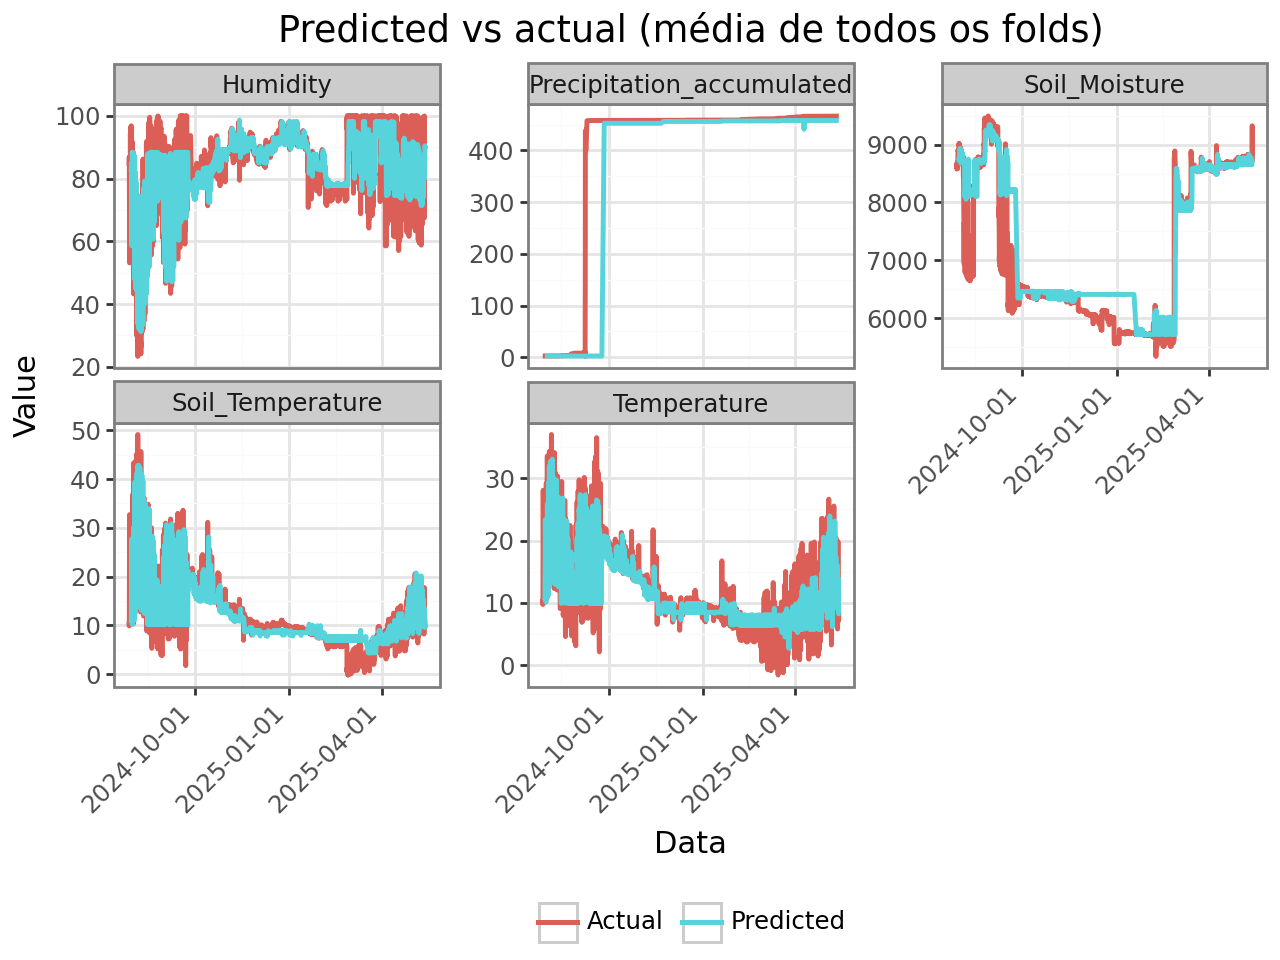

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_avg.png


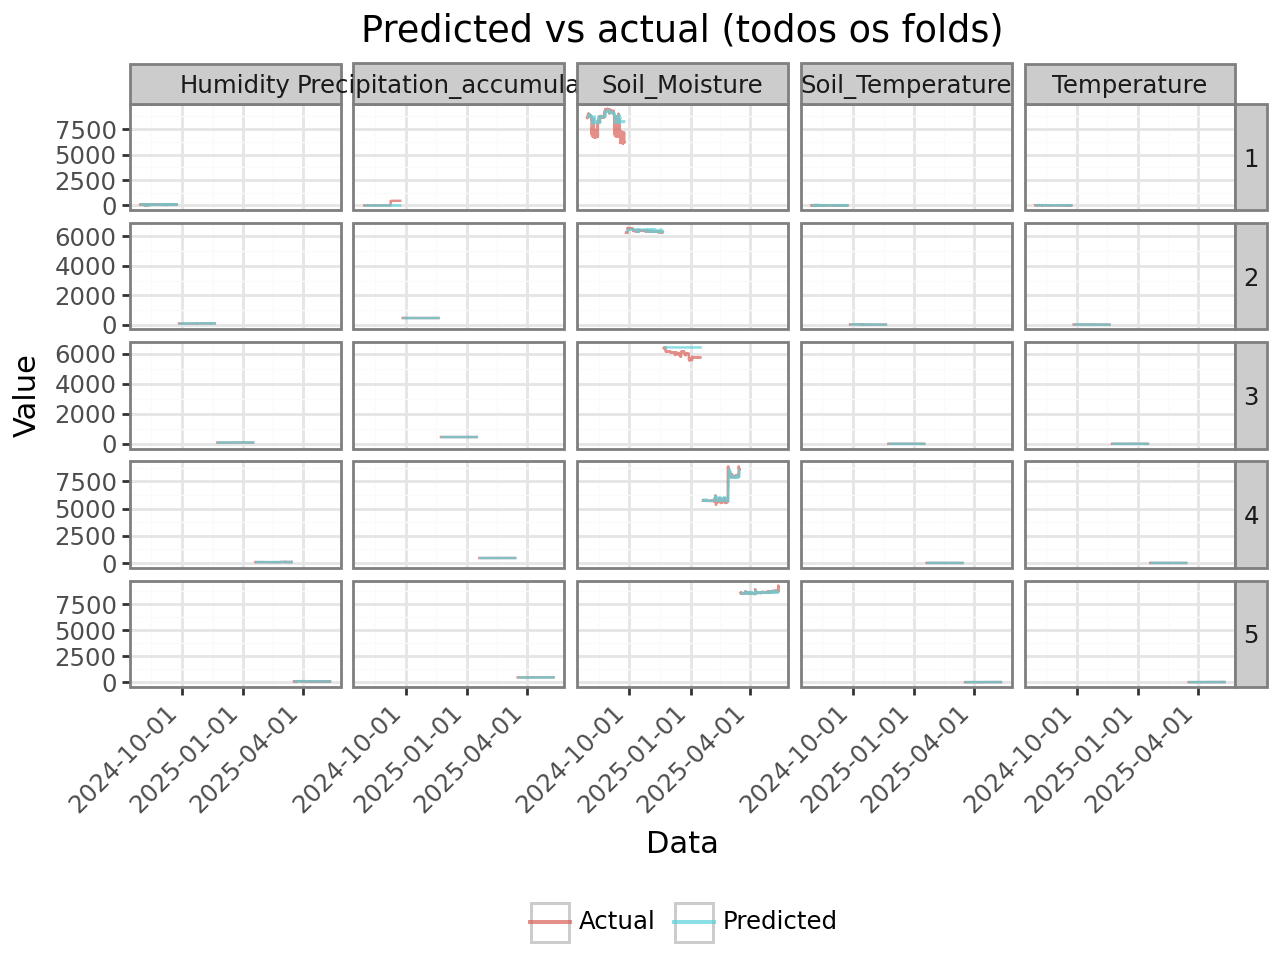

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 15 x 20 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_all_folds.png
/tmp/ipykernel_5422/688565223.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


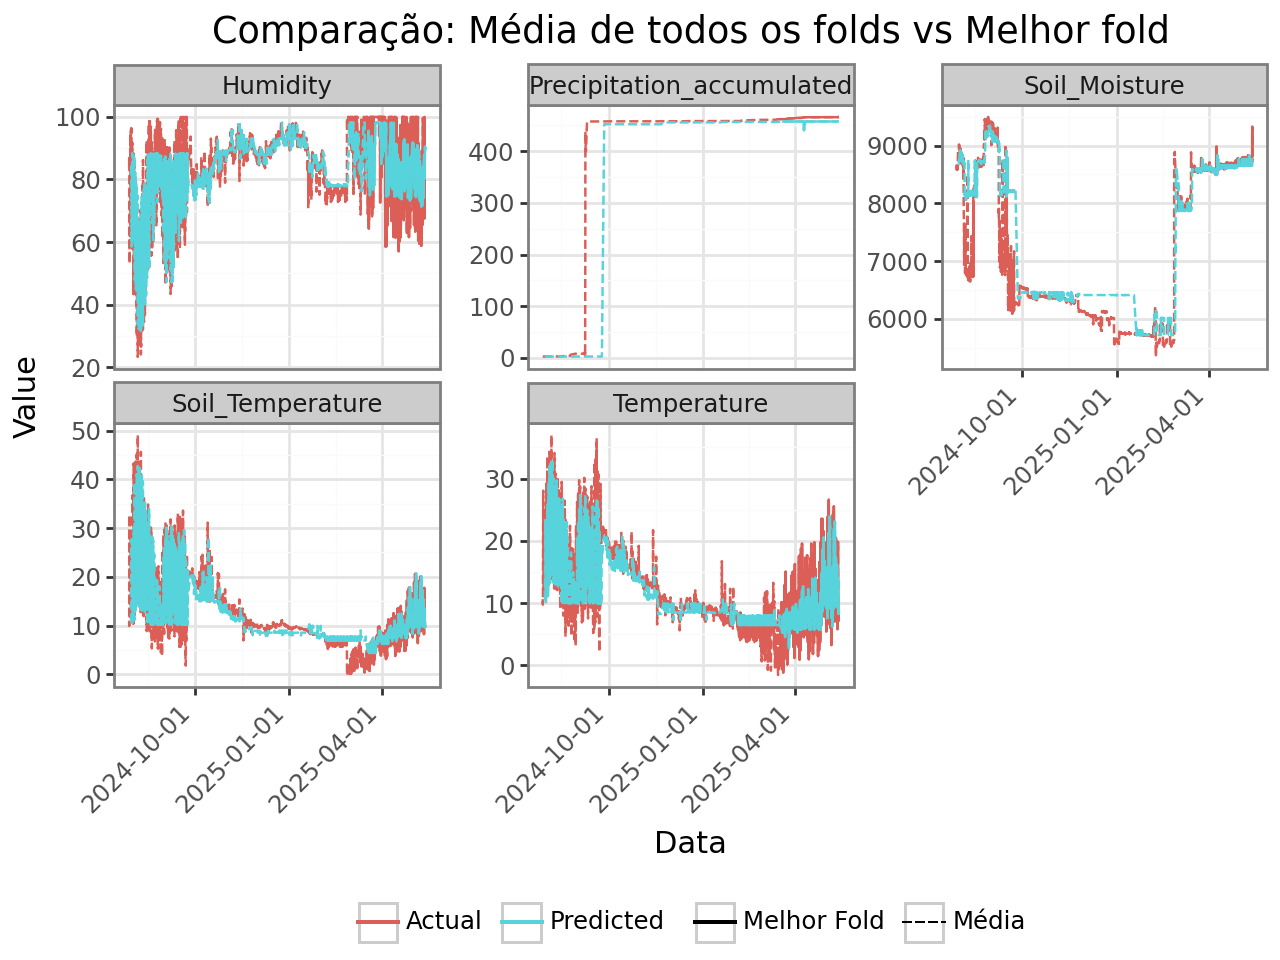

/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual_comparison.png


In [17]:
plot_columns = ['Timestamp', 'fold'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars=['Timestamp', 'fold'],
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

# Também criar uma versão agregada (média) para cada target e timestamp
df_avg = df_combined.groupby(['Date', 'target_column', 'type']).agg({'value': 'mean'}).reset_index()
df_avg['fold'] = 'Média'

# Combinar os dados médios com os dados originais
df_all = pd.concat([df_combined, df_avg])

# Plot 1: Média de todos os folds
plot_avg = (
    ggplot(df_avg, aes(x='Date', y='value', color='type'))
    + geom_line(size=1)
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (média de todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_avg.show()
plot_avg.save('predict_actual_avg.png', width=12, height=10, dpi=300)

# Plot 2: Todos os folds separados por target
plot_all_folds = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line(alpha=0.7)
    + facet_grid('fold ~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual (todos os folds)',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
        strip_text_y=element_text(angle=0)
    )
)
plot_all_folds.show()
plot_all_folds.save('predict_actual_all_folds.png', width=15, height=20, dpi=300)

# Plot 3: Comparação da média com o melhor fold
# Primeiro, preparar os dados do melhor fold
best_fold_data = df_combined[df_combined['fold'] == best_fold]
best_fold_data['fold'] = 'Melhor Fold'
comparison_data = pd.concat([df_avg, best_fold_data])

plot_comparison = (
    ggplot(comparison_data, aes(x='Date', y='value', color='type', linetype='fold'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Comparação: Média de todos os folds vs Melhor fold',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot_comparison.show()
plot_comparison.save('predict_actual_comparison.png', width=12, height=10, dpi=300)

In [18]:
# Salvar métricas do melhor fold
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)

# Salvar métricas médias
with open('avg_metrics.json', 'w') as f:
    json.dump(avg_metrics_df.to_dict(), f, indent=4)

# Salvar todas as métricas em um único arquivo
all_metrics = {
    'average': avg_metrics_df.to_dict(),
    'best_fold': best_metrics.to_dict(),
    'all_folds': {f'fold_{i+1}': df.to_dict() for i, df in enumerate(all_metrics_dfs)}
}
with open('all_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=4)

print("\nAnálise completa! Os resultados foram salvos usando a média de todos os folds.")



Análise completa! Os resultados foram salvos usando a média de todos os folds.
